In [ ]:
cd ../

In [2]:
import pickle
import numpy as np
import argparse
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist

import cxplain
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain
from tensorflow.python.keras.losses import binary_crossentropy, categorical_crossentropy

from tensorflow.python.keras.layers import Dense, Input, Flatten, Add, Multiply, Lambda
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from utils.explanations import calculate_robust_astute_sampled
import shap
import pickle
np.random.seed(0)

/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zulqarnain/anaconda3/envs/old_tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zulqarnain/anaconda3/envs/ol

In [3]:
def set_all_weights(model, all_layer_weights):
    count = 0
    for layer in model.layers:
        if type(layer) is Dense:
            count += 1
    if count == len(all_layer_weights):
        c = 0
        for layer in model.layers:
            if type(layer) is Dense:
                layer.set_weights(all_layer_weights[c])
                c += 1
        return model
    else:
        print("models don't match")

In [4]:
datatype = 'mnist'
run_times = 20
prop_points = 0.05
calculate = True
# epsilon_range = np.arange(0.01, 1.1, 0.05)
epsilon_range = [0.51]
masking_operation = ZeroMasking()
loss = categorical_crossentropy

In [5]:
mnist = pickle.load(open('data/mnist_10_10_train.pkl', 'rb'))
data = mnist[1]
labels = mnist[0]
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42)
x_train = np.array(x_train).reshape(-1, x_train[0].shape[0]*x_train[0].shape[1])
x_val = np.array(x_val).reshape(-1, x_val[0].shape[0]*x_val[0].shape[1])
y_train, y_val = np.array(y_train), np.array(y_val)
y_train, y_val = to_categorical(y_train), to_categorical(y_val)
input_shape = x_train.shape[-1] 

In [6]:
median_rad = np.median(pdist(x_train))

In [7]:
save_astuteness_file = 'plots/cxplain_' + datatype + '_astuteness_classifiers_lip_single_epsilon.pk'
lambda_dense_list = [float(1.5), float(2), float("inf")]
lambda_names = ['Regularized High', 'Regularized Low', 'Not Regularized']

In [8]:
if calculate:
    total_astuteness = np.zeros(shape=(run_times, len(lambda_dense_list), len(epsilon_range)))
    for i in range(run_times):
        print('Completing Run ' + str(i + 1) + ' of ' + str(run_times))
        for (j, lambda_dense) in enumerate(lambda_dense_list):
                all_layer_weights = pickle.load(open('extracted_weights/mnist_l2_' + str(j) + '.pk', 'rb'))
                activation = 'relu'

                model_input = Input(shape=(input_shape,), dtype='float32')

                net = Dense(32, activation=activation, name='dense1',
                            kernel_regularizer=regularizers.l2(1e-3))(model_input)
                net = Dense(32, activation=activation, name='dense2',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(32, activation=activation, name='dense3',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                net = Dense(32, activation=activation, name='dense4',
                            kernel_regularizer=regularizers.l2(1e-3))(net)
                preds = Dense(10, activation='softmax', name='dense5',
                              kernel_regularizer=regularizers.l2(1e-3))(net)
                bbox_model = Model(model_input, preds)
                bbox_model = set_all_weights(bbox_model, all_layer_weights)
                pred_model = Model(model_input, preds)
                model_builder = MLPModelBuilder(num_layers=4, num_units=32, activation=activation, verbose=1,
                                batch_size=32, learning_rate=0.001, num_epochs=5, early_stopping_patience=15,
                                with_bn=False)
                explainer = CXPlain(pred_model, model_builder, masking_operation, loss, num_models=1)
                explainer.fit(x_train, y_train)
                for k in tqdm(range(len(epsilon_range))):
                    _, total_astuteness[i, j, k], _ = calculate_robust_astute_sampled(data=x_val,
                                                                                      explainer=explainer,
                                                                                      explainer_type='cxplain',
                                                                                      explanation_type='attribution',
                                                                                      ball_r=median_rad,
                                                                                      epsilon=epsilon_range[k],
                                                                                      num_points=int(
                                                                                          prop_points * len(
                                                                                              x_val)),
                                                                                      NN=True,
                                                                                      data_explanation=None)     
    pickle.dump(total_astuteness, open(save_astuteness_file, 'wb'))
else:
    total_astuteness = pickle.load(open(save_astuteness_file, 'rb'))


Completing Run 1 of 20
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Train on 48600 samples, validate on 5400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
48600/48600 [==============================] - 3s 72us/sample - loss: 0.8025 - dense_4_loss: 0.7062 - all_loss: 0.0482 - lambda_1_loss: 0.0482 - val_loss: 0.6019 - val_dense_4_loss: 0.5058 - val_all_loss: 0.0481 - val_lambda_1_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 2s 44us/sample - loss: 0.5503 - dense_4_loss: 0.4539 - all_loss: 0.0482 - lambda_1_loss: 0.0482 - val_loss: 0.5059 - val_dense_4_loss: 0.4096 - val_all_loss: 0.0481 - val_lambda_1_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 2s 44us/sample - loss: 0.4904 - dense_4_loss: 0.3941 - all_loss: 0.0482 

100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 4s 75us/sample - loss: 1.1135 - dense_9_loss: 1.1042 - all_loss: 0.0046 - lambda_3_loss: 0.0046 - val_loss: 0.8320 - val_dense_9_loss: 0.8232 - val_all_loss: 0.0044 - val_lambda_3_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 2s 44us/sample - loss: 0.7957 - dense_9_loss: 0.7864 - all_loss: 0.0046 - lambda_3_loss: 0.0046 - val_loss: 0.7431 - val_dense_9_loss: 0.7344 - val_all_loss: 0.0044 - val_lambda_3_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 2s 44us/sample - loss: 0.7246 - dense_9_loss: 0.7153 - all_loss: 0.0046 - lambda_3_loss: 0.0046 - val_loss: 0.6923 - val_dense_9_loss: 0.6834 - val_all_loss: 0.0044 - val_lambda_3_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 2s 44us/sample - loss: 0.6844 - dense_9_loss: 0.6751 - all_loss: 0.0046 - lambda_3_loss: 0.0046 - val_loss: 0.6574 - val_dense_9_loss: 0.6487 - 

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 4s 85us/sample - loss: 1.6977 - dense_14_loss: 1.6951 - all_loss: 0.0013 - lambda_5_loss: 0.0013 - val_loss: 1.4248 - val_dense_14_loss: 1.4223 - val_all_loss: 0.0013 - val_lambda_5_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 2s 48us/sample - loss: 1.3660 - dense_14_loss: 1.3634 - all_loss: 0.0013 - lambda_5_loss: 0.0013 - val_loss: 1.3241 - val_dense_14_loss: 1.3217 - val_all_loss: 0.0013 - val_lambda_5_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 2s 48us/sample - loss: 1.2741 - dense_14_loss: 1.2716 - all_loss: 0.0013 - lambda_5_loss: 0.0013 - val_loss: 1.2446 - val_dense_14_loss: 1.2422 - val_all_loss: 0.0013 - val_lambda_5_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 2s 48us/sample - loss: 1.2184 - dense_14_loss: 1.2159 - all_loss: 0.0013 - lambda_5_loss: 0.0013 - val_loss: 1.2027 - val_dense_14_loss: 1

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Completing Run 2 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 4s 84us/sample - loss: 0.8036 - dense_19_loss: 0.7072 - all_loss: 0.0482 - lambda_7_loss: 0.0482 - val_loss: 0.5926 - val_dense_19_loss: 0.4963 - val_all_loss: 0.0481 - val_lambda_7_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 2s 48us/sample - loss: 0.5439 - dense_19_loss: 0.4476 - all_loss: 0.0482 - lambda_7_loss: 0.0482 - val_loss: 0.5012 - val_dense_19_loss: 0.4050 - val_all_loss: 0.0481 - val_lambda_7_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 2s 50us/sample - loss: 0.4812 - dense_19_loss: 0.3848 - all_loss: 0.0482 - lambda_7_loss: 0.0482 - val_loss: 0.4640 - val_dense_19_loss: 0.3678 - val_all_loss: 0.0481 - val_lambda_7_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 2s 49us/sample - loss: 0.4503 - dense_19_loss: 0.3540 - all_loss: 0.0482 - lambda_7_loss: 0.0482 - val_loss: 0.4388

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 7s 134us/sample - loss: 1.0974 - dense_24_loss: 1.0881 - all_loss: 0.0046 - lambda_9_loss: 0.0046 - val_loss: 0.8390 - val_dense_24_loss: 0.8304 - val_all_loss: 0.0044 - val_lambda_9_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 76us/sample - loss: 0.7833 - dense_24_loss: 0.7740 - all_loss: 0.0046 - lambda_9_loss: 0.0046 - val_loss: 0.7214 - val_dense_24_loss: 0.7127 - val_all_loss: 0.0044 - val_lambda_9_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 68us/sample - loss: 0.7032 - dense_24_loss: 0.6940 - all_loss: 0.0046 - lambda_9_loss: 0.0046 - val_loss: 0.6670 - val_dense_24_loss: 0.6583 - val_all_loss: 0.0044 - val_lambda_9_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 64us/sample - loss: 0.6621 - dense_24_loss: 0.6528 - all_loss: 0.0046 - lambda_9_loss: 0.0046 - val_loss: 0.6388 - val_dense_24_loss: 

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 8s 169us/sample - loss: 1.7145 - dense_29_loss: 1.7119 - all_loss: 0.0013 - lambda_11_loss: 0.0013 - val_loss: 1.4521 - val_dense_29_loss: 1.4491 - val_all_loss: 0.0013 - val_lambda_11_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 89us/sample - loss: 1.3810 - dense_29_loss: 1.3784 - all_loss: 0.0013 - lambda_11_loss: 0.0013 - val_loss: 1.3176 - val_dense_29_loss: 1.3148 - val_all_loss: 0.0013 - val_lambda_11_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 4s 85us/sample - loss: 1.2892 - dense_29_loss: 1.2867 - all_loss: 0.0013 - lambda_11_loss: 0.0013 - val_loss: 1.2555 - val_dense_29_loss: 1.2529 - val_all_loss: 0.0013 - val_lambda_11_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 4s 88us/sample - loss: 1.2321 - dense_29_loss: 1.2295 - all_loss: 0.0013 - lambda_11_loss: 0.0013 - val_loss: 1.2206 - val_dense_29

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Completing Run 3 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 8s 157us/sample - loss: 0.8152 - dense_34_loss: 0.7189 - all_loss: 0.0482 - lambda_13_loss: 0.0482 - val_loss: 0.6023 - val_dense_34_loss: 0.5061 - val_all_loss: 0.0481 - val_lambda_13_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 77us/sample - loss: 0.5552 - dense_34_loss: 0.4589 - all_loss: 0.0482 - lambda_13_loss: 0.0482 - val_loss: 0.5059 - val_dense_34_loss: 0.4096 - val_all_loss: 0.0481 - val_lambda_13_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 66us/sample - loss: 0.4890 - dense_34_loss: 0.3927 - all_loss: 0.0482 - lambda_13_loss: 0.0482 - val_loss: 0.4657 - val_dense_34_loss: 0.3695 - val_all_loss: 0.0481 - val_lambda_13_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 64us/sample - loss: 0.4553 - dense_34_loss: 0.3590 - all_loss: 0.0482 - lambda_13_loss: 0.0482 - val_loss

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 6s 127us/sample - loss: 1.0670 - dense_39_loss: 1.0577 - all_loss: 0.0046 - lambda_15_loss: 0.0046 - val_loss: 0.7885 - val_dense_39_loss: 0.7797 - val_all_loss: 0.0044 - val_lambda_15_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 60us/sample - loss: 0.7453 - dense_39_loss: 0.7360 - all_loss: 0.0046 - lambda_15_loss: 0.0046 - val_loss: 0.6967 - val_dense_39_loss: 0.6879 - val_all_loss: 0.0044 - val_lambda_15_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.6861 - dense_39_loss: 0.6768 - all_loss: 0.0046 - lambda_15_loss: 0.0046 - val_loss: 0.6564 - val_dense_39_loss: 0.6476 - val_all_loss: 0.0044 - val_lambda_15_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.6507 - dense_39_loss: 0.6414 - all_loss: 0.0046 - lambda_15_loss: 0.0046 - val_loss: 0.6210 - val_dense_39

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 6s 114us/sample - loss: 1.6790 - dense_44_loss: 1.6765 - all_loss: 0.0013 - lambda_17_loss: 0.0013 - val_loss: 1.4118 - val_dense_44_loss: 1.4094 - val_all_loss: 0.0013 - val_lambda_17_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 2s 49us/sample - loss: 1.3496 - dense_44_loss: 1.3470 - all_loss: 0.0013 - lambda_17_loss: 0.0013 - val_loss: 1.2897 - val_dense_44_loss: 1.2873 - val_all_loss: 0.0013 - val_lambda_17_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 2s 49us/sample - loss: 1.2582 - dense_44_loss: 1.2557 - all_loss: 0.0013 - lambda_17_loss: 0.0013 - val_loss: 1.2384 - val_dense_44_loss: 1.2362 - val_all_loss: 0.0013 - val_lambda_17_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 2s 49us/sample - loss: 1.2084 - dense_44_loss: 1.2059 - all_loss: 0.0013 - lambda_17_loss: 0.0013 - val_loss: 1.1904 - val_dense_44

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Completing Run 4 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 6s 122us/sample - loss: 0.8122 - dense_49_loss: 0.7158 - all_loss: 0.0482 - lambda_19_loss: 0.0482 - val_loss: 0.5799 - val_dense_49_loss: 0.4837 - val_all_loss: 0.0481 - val_lambda_19_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 2s 51us/sample - loss: 0.5330 - dense_49_loss: 0.4367 - all_loss: 0.0482 - lambda_19_loss: 0.0482 - val_loss: 0.4911 - val_dense_49_loss: 0.3947 - val_all_loss: 0.0481 - val_lambda_19_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 2s 51us/sample - loss: 0.4765 - dense_49_loss: 0.3801 - all_loss: 0.0482 - lambda_19_loss: 0.0482 - val_loss: 0.4526 - val_dense_49_loss: 0.3563 - val_all_loss: 0.0481 - val_lambda_19_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 2s 51us/sample - loss: 0.4469 - dense_49_loss: 0.3506 - all_loss: 0.0482 - lambda_19_loss: 0.0482 - val_loss

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 10s 199us/sample - loss: 1.0646 - dense_54_loss: 1.0553 - all_loss: 0.0046 - lambda_21_loss: 0.0046 - val_loss: 0.8037 - val_dense_54_loss: 0.7949 - val_all_loss: 0.0044 - val_lambda_21_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 62us/sample - loss: 0.7610 - dense_54_loss: 0.7517 - all_loss: 0.0046 - lambda_21_loss: 0.0046 - val_loss: 0.7142 - val_dense_54_loss: 0.7053 - val_all_loss: 0.0044 - val_lambda_21_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 63us/sample - loss: 0.6997 - dense_54_loss: 0.6904 - all_loss: 0.0046 - lambda_21_loss: 0.0046 - val_loss: 0.6729 - val_dense_54_loss: 0.6641 - val_all_loss: 0.0044 - val_lambda_21_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 72us/sample - loss: 0.6653 - dense_54_loss: 0.6560 - all_loss: 0.0046 - lambda_21_loss: 0.0046 - val_loss: 0.6432 - val_dense_5

100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 15s 317us/sample - loss: 1.6651 - dense_59_loss: 1.6625 - all_loss: 0.0013 - lambda_23_loss: 0.0013 - val_loss: 1.4107 - val_dense_59_loss: 1.4078 - val_all_loss: 0.0013 - val_lambda_23_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 5s 102us/sample - loss: 1.3538 - dense_59_loss: 1.3513 - all_loss: 0.0013 - lambda_23_loss: 0.0013 - val_loss: 1.3001 - val_dense_59_loss: 1.2976 - val_all_loss: 0.0013 - val_lambda_23_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 5s 102us/sample - loss: 1.2671 - dense_59_loss: 1.2645 - all_loss: 0.0013 - lambda_23_loss: 0.0013 - val_loss: 1.2378 - val_dense_59_loss: 1.2349 - val_all_loss: 0.0013 - val_lambda_23_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 101us/sample - loss: 1.2172 - dense_59_loss: 1.2148 - all_loss: 0.0013 - lambda_23_loss: 0.0013 - val_loss: 1.2212 - val_dens

100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Completing Run 5 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 13s 271us/sample - loss: 0.8007 - dense_64_loss: 0.7044 - all_loss: 0.0482 - lambda_25_loss: 0.0482 - val_loss: 0.5802 - val_dense_64_loss: 0.4840 - val_all_loss: 0.0481 - val_lambda_25_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 5s 107us/sample - loss: 0.5392 - dense_64_loss: 0.4429 - all_loss: 0.0482 - lambda_25_loss: 0.0482 - val_loss: 0.4975 - val_dense_64_loss: 0.4013 - val_all_loss: 0.0481 - val_lambda_25_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 5s 112us/sample - loss: 0.4824 - dense_64_loss: 0.3861 - all_loss: 0.0482 - lambda_25_loss: 0.0482 - val_loss: 0.4622 - val_dense_64_loss: 0.3660 - val_all_loss: 0.0481 - val_lambda_25_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 5s 105us/sample - loss: 0.4528 - dense_64_loss: 0.3565 - all_loss: 0.0482 - lambda_25_loss: 0.0482 - val_

100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 9s 177us/sample - loss: 1.0642 - dense_69_loss: 1.0549 - all_loss: 0.0046 - lambda_27_loss: 0.0046 - val_loss: 0.8104 - val_dense_69_loss: 0.8017 - val_all_loss: 0.0044 - val_lambda_27_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 58us/sample - loss: 0.7607 - dense_69_loss: 0.7514 - all_loss: 0.0046 - lambda_27_loss: 0.0046 - val_loss: 0.7111 - val_dense_69_loss: 0.7023 - val_all_loss: 0.0044 - val_lambda_27_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 57us/sample - loss: 0.6929 - dense_69_loss: 0.6836 - all_loss: 0.0046 - lambda_27_loss: 0.0046 - val_loss: 0.6652 - val_dense_69_loss: 0.6567 - val_all_loss: 0.0044 - val_lambda_27_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 57us/sample - loss: 0.6569 - dense_69_loss: 0.6476 - all_loss: 0.0046 - lambda_27_loss: 0.0046 - val_loss: 0.6437 - val_dense_69

100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 8s 161us/sample - loss: 1.7024 - dense_74_loss: 1.6999 - all_loss: 0.0013 - lambda_29_loss: 0.0013 - val_loss: 1.4244 - val_dense_74_loss: 1.4218 - val_all_loss: 0.0013 - val_lambda_29_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 3s 55us/sample - loss: 1.3473 - dense_74_loss: 1.3447 - all_loss: 0.0013 - lambda_29_loss: 0.0013 - val_loss: 1.2980 - val_dense_74_loss: 1.2948 - val_all_loss: 0.0013 - val_lambda_29_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 54us/sample - loss: 1.2623 - dense_74_loss: 1.2598 - all_loss: 0.0013 - lambda_29_loss: 0.0013 - val_loss: 1.2298 - val_dense_74_loss: 1.2268 - val_all_loss: 0.0013 - val_lambda_29_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 54us/sample - loss: 1.2122 - dense_74_loss: 1.2096 - all_loss: 0.0013 - lambda_29_loss: 0.0013 - val_loss: 1.1925 - val_dense_74

100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Completing Run 6 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 8s 168us/sample - loss: 0.7973 - dense_79_loss: 0.7010 - all_loss: 0.0482 - lambda_31_loss: 0.0482 - val_loss: 0.5793 - val_dense_79_loss: 0.4833 - val_all_loss: 0.0481 - val_lambda_31_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 3s 56us/sample - loss: 0.5411 - dense_79_loss: 0.4448 - all_loss: 0.0482 - lambda_31_loss: 0.0482 - val_loss: 0.4950 - val_dense_79_loss: 0.3987 - val_all_loss: 0.0481 - val_lambda_31_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 57us/sample - loss: 0.4837 - dense_79_loss: 0.3874 - all_loss: 0.0482 - lambda_31_loss: 0.0482 - val_loss: 0.4592 - val_dense_79_loss: 0.3630 - val_all_loss: 0.0481 - val_lambda_31_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 56us/sample - loss: 0.4510 - dense_79_loss: 0.3546 - all_loss: 0.0482 - lambda_31_loss: 0.0482 - val_loss

100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 9s 178us/sample - loss: 1.1209 - dense_84_loss: 1.1116 - all_loss: 0.0046 - lambda_33_loss: 0.0046 - val_loss: 0.8368 - val_dense_84_loss: 0.8282 - val_all_loss: 0.0044 - val_lambda_33_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 55us/sample - loss: 0.7809 - dense_84_loss: 0.7717 - all_loss: 0.0046 - lambda_33_loss: 0.0046 - val_loss: 0.7333 - val_dense_84_loss: 0.7243 - val_all_loss: 0.0044 - val_lambda_33_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 55us/sample - loss: 0.7047 - dense_84_loss: 0.6955 - all_loss: 0.0046 - lambda_33_loss: 0.0046 - val_loss: 0.6755 - val_dense_84_loss: 0.6669 - val_all_loss: 0.0044 - val_lambda_33_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 54us/sample - loss: 0.6635 - dense_84_loss: 0.6542 - all_loss: 0.0046 - lambda_33_loss: 0.0046 - val_loss: 0.6467 - val_dense_84

100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 9s 185us/sample - loss: 1.6848 - dense_89_loss: 1.6823 - all_loss: 0.0013 - lambda_35_loss: 0.0013 - val_loss: 1.4213 - val_dense_89_loss: 1.4187 - val_all_loss: 0.0013 - val_lambda_35_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 3s 57us/sample - loss: 1.3656 - dense_89_loss: 1.3630 - all_loss: 0.0013 - lambda_35_loss: 0.0013 - val_loss: 1.3114 - val_dense_89_loss: 1.3083 - val_all_loss: 0.0013 - val_lambda_35_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 57us/sample - loss: 1.2780 - dense_89_loss: 1.2754 - all_loss: 0.0013 - lambda_35_loss: 0.0013 - val_loss: 1.2420 - val_dense_89_loss: 1.2389 - val_all_loss: 0.0013 - val_lambda_35_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 57us/sample - loss: 1.2207 - dense_89_loss: 1.2181 - all_loss: 0.0013 - lambda_35_loss: 0.0013 - val_loss: 1.2050 - val_dense_89

100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Completing Run 7 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 9s 193us/sample - loss: 0.8080 - dense_94_loss: 0.7117 - all_loss: 0.0482 - lambda_37_loss: 0.0482 - val_loss: 0.5945 - val_dense_94_loss: 0.4983 - val_all_loss: 0.0481 - val_lambda_37_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 3s 59us/sample - loss: 0.5565 - dense_94_loss: 0.4601 - all_loss: 0.0482 - lambda_37_loss: 0.0482 - val_loss: 0.5138 - val_dense_94_loss: 0.4175 - val_all_loss: 0.0481 - val_lambda_37_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 60us/sample - loss: 0.4954 - dense_94_loss: 0.3991 - all_loss: 0.0482 - lambda_37_loss: 0.0482 - val_loss: 0.4711 - val_dense_94_loss: 0.3748 - val_all_loss: 0.0481 - val_lambda_37_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 59us/sample - loss: 0.4619 - dense_94_loss: 0.3656 - all_loss: 0.0482 - lambda_37_loss: 0.0482 - val_loss

100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 10s 201us/sample - loss: 1.0735 - dense_99_loss: 1.0642 - all_loss: 0.0046 - lambda_39_loss: 0.0046 - val_loss: 0.8100 - val_dense_99_loss: 0.8012 - val_all_loss: 0.0044 - val_lambda_39_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.7660 - dense_99_loss: 0.7567 - all_loss: 0.0046 - lambda_39_loss: 0.0046 - val_loss: 0.7355 - val_dense_99_loss: 0.7267 - val_all_loss: 0.0044 - val_lambda_39_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.6990 - dense_99_loss: 0.6897 - all_loss: 0.0046 - lambda_39_loss: 0.0046 - val_loss: 0.6703 - val_dense_99_loss: 0.6616 - val_all_loss: 0.0044 - val_lambda_39_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.6572 - dense_99_loss: 0.6480 - all_loss: 0.0046 - lambda_39_loss: 0.0046 - val_loss: 0.6385 - val_dense_9

100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 10s 208us/sample - loss: 1.6877 - dense_104_loss: 1.6851 - all_loss: 0.0013 - lambda_41_loss: 0.0013 - val_loss: 1.4228 - val_dense_104_loss: 1.4201 - val_all_loss: 0.0013 - val_lambda_41_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 3s 59us/sample - loss: 1.3669 - dense_104_loss: 1.3643 - all_loss: 0.0013 - lambda_41_loss: 0.0013 - val_loss: 1.3039 - val_dense_104_loss: 1.3014 - val_all_loss: 0.0013 - val_lambda_41_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 58us/sample - loss: 1.2798 - dense_104_loss: 1.2773 - all_loss: 0.0013 - lambda_41_loss: 0.0013 - val_loss: 1.2532 - val_dense_104_loss: 1.2511 - val_all_loss: 0.0013 - val_lambda_41_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 59us/sample - loss: 1.2261 - dense_104_loss: 1.2236 - all_loss: 0.0013 - lambda_41_loss: 0.0013 - val_loss: 1.2193 - val_

100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Completing Run 8 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 11s 217us/sample - loss: 0.8411 - dense_109_loss: 0.7448 - all_loss: 0.0482 - lambda_43_loss: 0.0482 - val_loss: 0.6053 - val_dense_109_loss: 0.5093 - val_all_loss: 0.0481 - val_lambda_43_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 3s 60us/sample - loss: 0.5595 - dense_109_loss: 0.4632 - all_loss: 0.0482 - lambda_43_loss: 0.0482 - val_loss: 0.5147 - val_dense_109_loss: 0.4186 - val_all_loss: 0.0481 - val_lambda_43_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 60us/sample - loss: 0.4979 - dense_109_loss: 0.4016 - all_loss: 0.0482 - lambda_43_loss: 0.0482 - val_loss: 0.4804 - val_dense_109_loss: 0.3840 - val_all_loss: 0.0481 - val_lambda_43_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 61us/sample - loss: 0.4626 - dense_109_loss: 0.3663 - all_loss: 0.0482 - lambda_43_loss: 0.0482 - 

100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 11s 227us/sample - loss: 1.1003 - dense_114_loss: 1.0909 - all_loss: 0.0046 - lambda_45_loss: 0.0046 - val_loss: 0.8407 - val_dense_114_loss: 0.8318 - val_all_loss: 0.0044 - val_lambda_45_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 63us/sample - loss: 0.7878 - dense_114_loss: 0.7786 - all_loss: 0.0046 - lambda_45_loss: 0.0046 - val_loss: 0.7574 - val_dense_114_loss: 0.7485 - val_all_loss: 0.0044 - val_lambda_45_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 63us/sample - loss: 0.7116 - dense_114_loss: 0.7023 - all_loss: 0.0046 - lambda_45_loss: 0.0046 - val_loss: 0.6776 - val_dense_114_loss: 0.6690 - val_all_loss: 0.0044 - val_lambda_45_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 63us/sample - loss: 0.6664 - dense_114_loss: 0.6571 - all_loss: 0.0046 - lambda_45_loss: 0.0046 - val_loss: 0.6440 - val_

100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 11s 236us/sample - loss: 1.7432 - dense_119_loss: 1.7406 - all_loss: 0.0013 - lambda_47_loss: 0.0013 - val_loss: 1.4500 - val_dense_119_loss: 1.4472 - val_all_loss: 0.0013 - val_lambda_47_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 3s 64us/sample - loss: 1.3695 - dense_119_loss: 1.3670 - all_loss: 0.0013 - lambda_47_loss: 0.0013 - val_loss: 1.3120 - val_dense_119_loss: 1.3092 - val_all_loss: 0.0013 - val_lambda_47_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 65us/sample - loss: 1.2777 - dense_119_loss: 1.2751 - all_loss: 0.0013 - lambda_47_loss: 0.0013 - val_loss: 1.2508 - val_dense_119_loss: 1.2486 - val_all_loss: 0.0013 - val_lambda_47_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 65us/sample - loss: 1.2261 - dense_119_loss: 1.2236 - all_loss: 0.0013 - lambda_47_loss: 0.0013 - val_loss: 1.2024 - val_

100%|██████████| 1/1 [00:04<00:00,  4.83s/it]


Completing Run 9 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 12s 246us/sample - loss: 0.8145 - dense_124_loss: 0.7182 - all_loss: 0.0482 - lambda_49_loss: 0.0482 - val_loss: 0.5882 - val_dense_124_loss: 0.4922 - val_all_loss: 0.0481 - val_lambda_49_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 3s 68us/sample - loss: 0.5432 - dense_124_loss: 0.4468 - all_loss: 0.0482 - lambda_49_loss: 0.0482 - val_loss: 0.4965 - val_dense_124_loss: 0.4002 - val_all_loss: 0.0481 - val_lambda_49_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 67us/sample - loss: 0.4884 - dense_124_loss: 0.3921 - all_loss: 0.0482 - lambda_49_loss: 0.0482 - val_loss: 0.4658 - val_dense_124_loss: 0.3696 - val_all_loss: 0.0481 - val_lambda_49_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 67us/sample - loss: 0.4599 - dense_124_loss: 0.3636 - all_loss: 0.0482 - lambda_49_loss: 0.0482 - 

100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 13s 258us/sample - loss: 1.0910 - dense_129_loss: 1.0817 - all_loss: 0.0046 - lambda_51_loss: 0.0046 - val_loss: 0.8219 - val_dense_129_loss: 0.8133 - val_all_loss: 0.0044 - val_lambda_51_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 70us/sample - loss: 0.7826 - dense_129_loss: 0.7734 - all_loss: 0.0046 - lambda_51_loss: 0.0046 - val_loss: 0.7299 - val_dense_129_loss: 0.7208 - val_all_loss: 0.0044 - val_lambda_51_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 70us/sample - loss: 0.7132 - dense_129_loss: 0.7039 - all_loss: 0.0046 - lambda_51_loss: 0.0046 - val_loss: 0.6847 - val_dense_129_loss: 0.6759 - val_all_loss: 0.0044 - val_lambda_51_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 69us/sample - loss: 0.6712 - dense_129_loss: 0.6620 - all_loss: 0.0046 - lambda_51_loss: 0.0046 - val_loss: 0.6469 - val_

100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 13s 270us/sample - loss: 1.6759 - dense_134_loss: 1.6733 - all_loss: 0.0013 - lambda_53_loss: 0.0013 - val_loss: 1.3846 - val_dense_134_loss: 1.3817 - val_all_loss: 0.0013 - val_lambda_53_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 3s 65us/sample - loss: 1.3396 - dense_134_loss: 1.3370 - all_loss: 0.0013 - lambda_53_loss: 0.0013 - val_loss: 1.2911 - val_dense_134_loss: 1.2882 - val_all_loss: 0.0013 - val_lambda_53_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 65us/sample - loss: 1.2624 - dense_134_loss: 1.2599 - all_loss: 0.0013 - lambda_53_loss: 0.0013 - val_loss: 1.2439 - val_dense_134_loss: 1.2415 - val_all_loss: 0.0013 - val_lambda_53_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 64us/sample - loss: 1.2074 - dense_134_loss: 1.2049 - all_loss: 0.0013 - lambda_53_loss: 0.0013 - val_loss: 1.1791 - val_

100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Completing Run 10 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 14s 279us/sample - loss: 0.8279 - dense_139_loss: 0.7315 - all_loss: 0.0482 - lambda_55_loss: 0.0482 - val_loss: 0.6098 - val_dense_139_loss: 0.5134 - val_all_loss: 0.0481 - val_lambda_55_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 3s 67us/sample - loss: 0.5628 - dense_139_loss: 0.4665 - all_loss: 0.0482 - lambda_55_loss: 0.0482 - val_loss: 0.5170 - val_dense_139_loss: 0.4208 - val_all_loss: 0.0481 - val_lambda_55_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 3s 67us/sample - loss: 0.5022 - dense_139_loss: 0.4059 - all_loss: 0.0482 - lambda_55_loss: 0.0482 - val_loss: 0.4813 - val_dense_139_loss: 0.3851 - val_all_loss: 0.0481 - val_lambda_55_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 3s 66us/sample - loss: 0.4717 - dense_139_loss: 0.3754 - all_loss: 0.0482 - lambda_55_loss: 0.0482 -

100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 14s 288us/sample - loss: 1.0981 - dense_144_loss: 1.0888 - all_loss: 0.0046 - lambda_57_loss: 0.0046 - val_loss: 0.8343 - val_dense_144_loss: 0.8256 - val_all_loss: 0.0044 - val_lambda_57_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 3s 69us/sample - loss: 0.7896 - dense_144_loss: 0.7803 - all_loss: 0.0046 - lambda_57_loss: 0.0046 - val_loss: 0.7287 - val_dense_144_loss: 0.7198 - val_all_loss: 0.0044 - val_lambda_57_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 3s 70us/sample - loss: 0.7164 - dense_144_loss: 0.7071 - all_loss: 0.0046 - lambda_57_loss: 0.0046 - val_loss: 0.6861 - val_dense_144_loss: 0.6773 - val_all_loss: 0.0044 - val_lambda_57_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 3s 68us/sample - loss: 0.6767 - dense_144_loss: 0.6674 - all_loss: 0.0046 - lambda_57_loss: 0.0046 - val_loss: 0.6567 - val_

100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 14s 297us/sample - loss: 1.7037 - dense_149_loss: 1.7011 - all_loss: 0.0013 - lambda_59_loss: 0.0013 - val_loss: 1.4311 - val_dense_149_loss: 1.4284 - val_all_loss: 0.0013 - val_lambda_59_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 73us/sample - loss: 1.3615 - dense_149_loss: 1.3589 - all_loss: 0.0013 - lambda_59_loss: 0.0013 - val_loss: 1.3045 - val_dense_149_loss: 1.3014 - val_all_loss: 0.0013 - val_lambda_59_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 71us/sample - loss: 1.2684 - dense_149_loss: 1.2658 - all_loss: 0.0013 - lambda_59_loss: 0.0013 - val_loss: 1.2427 - val_dense_149_loss: 1.2398 - val_all_loss: 0.0013 - val_lambda_59_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 72us/sample - loss: 1.2165 - dense_149_loss: 1.2140 - all_loss: 0.0013 - lambda_59_loss: 0.0013 - val_loss: 1.2118 - val_

100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


Completing Run 11 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 15s 309us/sample - loss: 0.7954 - dense_154_loss: 0.6991 - all_loss: 0.0482 - lambda_61_loss: 0.0482 - val_loss: 0.5785 - val_dense_154_loss: 0.4822 - val_all_loss: 0.0481 - val_lambda_61_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 74us/sample - loss: 0.5425 - dense_154_loss: 0.4462 - all_loss: 0.0482 - lambda_61_loss: 0.0482 - val_loss: 0.4992 - val_dense_154_loss: 0.4030 - val_all_loss: 0.0481 - val_lambda_61_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 4s 74us/sample - loss: 0.4876 - dense_154_loss: 0.3913 - all_loss: 0.0482 - lambda_61_loss: 0.0482 - val_loss: 0.4637 - val_dense_154_loss: 0.3674 - val_all_loss: 0.0481 - val_lambda_61_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 4s 75us/sample - loss: 0.4555 - dense_154_loss: 0.3592 - all_loss: 0.0482 - lambda_61_loss: 0.0482 -

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 16s 319us/sample - loss: 1.0665 - dense_159_loss: 1.0572 - all_loss: 0.0046 - lambda_63_loss: 0.0046 - val_loss: 0.8002 - val_dense_159_loss: 0.7913 - val_all_loss: 0.0044 - val_lambda_63_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 77us/sample - loss: 0.7582 - dense_159_loss: 0.7489 - all_loss: 0.0046 - lambda_63_loss: 0.0046 - val_loss: 0.7048 - val_dense_159_loss: 0.6959 - val_all_loss: 0.0044 - val_lambda_63_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 4s 76us/sample - loss: 0.6912 - dense_159_loss: 0.6819 - all_loss: 0.0046 - lambda_63_loss: 0.0046 - val_loss: 0.6645 - val_dense_159_loss: 0.6559 - val_all_loss: 0.0044 - val_lambda_63_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 77us/sample - loss: 0.6548 - dense_159_loss: 0.6456 - all_loss: 0.0046 - lambda_63_loss: 0.0046 - val_loss: 0.6315 - val_

100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 16s 329us/sample - loss: 1.6927 - dense_164_loss: 1.6902 - all_loss: 0.0013 - lambda_65_loss: 0.0013 - val_loss: 1.4290 - val_dense_164_loss: 1.4265 - val_all_loss: 0.0013 - val_lambda_65_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 72us/sample - loss: 1.3670 - dense_164_loss: 1.3644 - all_loss: 0.0013 - lambda_65_loss: 0.0013 - val_loss: 1.3064 - val_dense_164_loss: 1.3038 - val_all_loss: 0.0013 - val_lambda_65_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 3s 71us/sample - loss: 1.2755 - dense_164_loss: 1.2729 - all_loss: 0.0013 - lambda_65_loss: 0.0013 - val_loss: 1.2446 - val_dense_164_loss: 1.2419 - val_all_loss: 0.0013 - val_lambda_65_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 3s 72us/sample - loss: 1.2223 - dense_164_loss: 1.2198 - all_loss: 0.0013 - lambda_65_loss: 0.0013 - val_loss: 1.2075 - val_

100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


Completing Run 12 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 17s 340us/sample - loss: 0.7987 - dense_169_loss: 0.7024 - all_loss: 0.0482 - lambda_67_loss: 0.0482 - val_loss: 0.5849 - val_dense_169_loss: 0.4887 - val_all_loss: 0.0481 - val_lambda_67_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 74us/sample - loss: 0.5398 - dense_169_loss: 0.4435 - all_loss: 0.0482 - lambda_67_loss: 0.0482 - val_loss: 0.4959 - val_dense_169_loss: 0.3995 - val_all_loss: 0.0481 - val_lambda_67_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 4s 74us/sample - loss: 0.4845 - dense_169_loss: 0.3882 - all_loss: 0.0482 - lambda_67_loss: 0.0482 - val_loss: 0.4703 - val_dense_169_loss: 0.3741 - val_all_loss: 0.0481 - val_lambda_67_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 4s 74us/sample - loss: 0.4552 - dense_169_loss: 0.3589 - all_loss: 0.0482 - lambda_67_loss: 0.0482 -

100%|██████████| 1/1 [00:07<00:00,  7.59s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 17s 352us/sample - loss: 1.1055 - dense_174_loss: 1.0961 - all_loss: 0.0046 - lambda_69_loss: 0.0046 - val_loss: 0.8252 - val_dense_174_loss: 0.8164 - val_all_loss: 0.0044 - val_lambda_69_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 78us/sample - loss: 0.7747 - dense_174_loss: 0.7654 - all_loss: 0.0046 - lambda_69_loss: 0.0046 - val_loss: 0.7122 - val_dense_174_loss: 0.7035 - val_all_loss: 0.0044 - val_lambda_69_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 4s 76us/sample - loss: 0.7021 - dense_174_loss: 0.6929 - all_loss: 0.0046 - lambda_69_loss: 0.0046 - val_loss: 0.6677 - val_dense_174_loss: 0.6590 - val_all_loss: 0.0044 - val_lambda_69_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 76us/sample - loss: 0.6652 - dense_174_loss: 0.6559 - all_loss: 0.0046 - lambda_69_loss: 0.0046 - val_loss: 0.6345 - val_

100%|██████████| 1/1 [00:07<00:00,  7.94s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 17s 360us/sample - loss: 1.6703 - dense_179_loss: 1.6677 - all_loss: 0.0013 - lambda_71_loss: 0.0013 - val_loss: 1.4067 - val_dense_179_loss: 1.4043 - val_all_loss: 0.0013 - val_lambda_71_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 80us/sample - loss: 1.3463 - dense_179_loss: 1.3438 - all_loss: 0.0013 - lambda_71_loss: 0.0013 - val_loss: 1.2943 - val_dense_179_loss: 1.2915 - val_all_loss: 0.0013 - val_lambda_71_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 4s 80us/sample - loss: 1.2577 - dense_179_loss: 1.2551 - all_loss: 0.0013 - lambda_71_loss: 0.0013 - val_loss: 1.2314 - val_dense_179_loss: 1.2288 - val_all_loss: 0.0013 - val_lambda_71_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 4s 80us/sample - loss: 1.2013 - dense_179_loss: 1.1987 - all_loss: 0.0013 - lambda_71_loss: 0.0013 - val_loss: 1.1886 - val_

100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


Completing Run 13 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 18s 372us/sample - loss: 0.7837 - dense_184_loss: 0.6873 - all_loss: 0.0482 - lambda_73_loss: 0.0482 - val_loss: 0.5841 - val_dense_184_loss: 0.4880 - val_all_loss: 0.0481 - val_lambda_73_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 83us/sample - loss: 0.5390 - dense_184_loss: 0.4427 - all_loss: 0.0482 - lambda_73_loss: 0.0482 - val_loss: 0.5014 - val_dense_184_loss: 0.4050 - val_all_loss: 0.0481 - val_lambda_73_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 4s 82us/sample - loss: 0.4829 - dense_184_loss: 0.3866 - all_loss: 0.0482 - lambda_73_loss: 0.0482 - val_loss: 0.4650 - val_dense_184_loss: 0.3686 - val_all_loss: 0.0481 - val_lambda_73_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 4s 82us/sample - loss: 0.4521 - dense_184_loss: 0.3558 - all_loss: 0.0482 - lambda_73_loss: 0.0482 -

100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 19s 387us/sample - loss: 1.0821 - dense_189_loss: 1.0728 - all_loss: 0.0046 - lambda_75_loss: 0.0046 - val_loss: 0.8128 - val_dense_189_loss: 0.8040 - val_all_loss: 0.0044 - val_lambda_75_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 86us/sample - loss: 0.7624 - dense_189_loss: 0.7531 - all_loss: 0.0046 - lambda_75_loss: 0.0046 - val_loss: 0.7125 - val_dense_189_loss: 0.7037 - val_all_loss: 0.0044 - val_lambda_75_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 4s 84us/sample - loss: 0.6931 - dense_189_loss: 0.6839 - all_loss: 0.0046 - lambda_75_loss: 0.0046 - val_loss: 0.6586 - val_dense_189_loss: 0.6498 - val_all_loss: 0.0044 - val_lambda_75_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 85us/sample - loss: 0.6546 - dense_189_loss: 0.6453 - all_loss: 0.0046 - lambda_75_loss: 0.0046 - val_loss: 0.6330 - val_

100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 19s 396us/sample - loss: 1.6633 - dense_194_loss: 1.6607 - all_loss: 0.0013 - lambda_77_loss: 0.0013 - val_loss: 1.4124 - val_dense_194_loss: 1.4096 - val_all_loss: 0.0013 - val_lambda_77_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 88us/sample - loss: 1.3399 - dense_194_loss: 1.3373 - all_loss: 0.0013 - lambda_77_loss: 0.0013 - val_loss: 1.2876 - val_dense_194_loss: 1.2856 - val_all_loss: 0.0013 - val_lambda_77_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 4s 89us/sample - loss: 1.2560 - dense_194_loss: 1.2535 - all_loss: 0.0013 - lambda_77_loss: 0.0013 - val_loss: 1.2388 - val_dense_194_loss: 1.2362 - val_all_loss: 0.0013 - val_lambda_77_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 4s 88us/sample - loss: 1.2070 - dense_194_loss: 1.2045 - all_loss: 0.0013 - lambda_77_loss: 0.0013 - val_loss: 1.1821 - val_

100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Completing Run 14 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 20s 406us/sample - loss: 0.8142 - dense_199_loss: 0.7178 - all_loss: 0.0482 - lambda_79_loss: 0.0482 - val_loss: 0.5973 - val_dense_199_loss: 0.5012 - val_all_loss: 0.0481 - val_lambda_79_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 91us/sample - loss: 0.5498 - dense_199_loss: 0.4535 - all_loss: 0.0482 - lambda_79_loss: 0.0482 - val_loss: 0.5041 - val_dense_199_loss: 0.4078 - val_all_loss: 0.0481 - val_lambda_79_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 4s 88us/sample - loss: 0.4887 - dense_199_loss: 0.3924 - all_loss: 0.0482 - lambda_79_loss: 0.0482 - val_loss: 0.4667 - val_dense_199_loss: 0.3704 - val_all_loss: 0.0481 - val_lambda_79_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 4s 90us/sample - loss: 0.4558 - dense_199_loss: 0.3595 - all_loss: 0.0482 - lambda_79_loss: 0.0482 -

100%|██████████| 1/1 [00:09<00:00,  9.43s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 20s 419us/sample - loss: 1.0986 - dense_204_loss: 1.0893 - all_loss: 0.0046 - lambda_81_loss: 0.0046 - val_loss: 0.8217 - val_dense_204_loss: 0.8130 - val_all_loss: 0.0044 - val_lambda_81_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 82us/sample - loss: 0.7692 - dense_204_loss: 0.7599 - all_loss: 0.0046 - lambda_81_loss: 0.0046 - val_loss: 0.7174 - val_dense_204_loss: 0.7086 - val_all_loss: 0.0044 - val_lambda_81_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 4s 81us/sample - loss: 0.7003 - dense_204_loss: 0.6910 - all_loss: 0.0046 - lambda_81_loss: 0.0046 - val_loss: 0.6721 - val_dense_204_loss: 0.6633 - val_all_loss: 0.0044 - val_lambda_81_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 81us/sample - loss: 0.6620 - dense_204_loss: 0.6527 - all_loss: 0.0046 - lambda_81_loss: 0.0046 - val_loss: 0.6407 - val_

100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 21s 431us/sample - loss: 1.7307 - dense_209_loss: 1.7281 - all_loss: 0.0013 - lambda_83_loss: 0.0013 - val_loss: 1.4686 - val_dense_209_loss: 1.4663 - val_all_loss: 0.0013 - val_lambda_83_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 4s 86us/sample - loss: 1.3914 - dense_209_loss: 1.3889 - all_loss: 0.0013 - lambda_83_loss: 0.0013 - val_loss: 1.3345 - val_dense_209_loss: 1.3316 - val_all_loss: 0.0013 - val_lambda_83_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 4s 84us/sample - loss: 1.2937 - dense_209_loss: 1.2912 - all_loss: 0.0013 - lambda_83_loss: 0.0013 - val_loss: 1.2785 - val_dense_209_loss: 1.2760 - val_all_loss: 0.0013 - val_lambda_83_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 4s 83us/sample - loss: 1.2308 - dense_209_loss: 1.2283 - all_loss: 0.0013 - lambda_83_loss: 0.0013 - val_loss: 1.2287 - val_

100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


Completing Run 15 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 22s 445us/sample - loss: 0.7939 - dense_214_loss: 0.6975 - all_loss: 0.0482 - lambda_85_loss: 0.0482 - val_loss: 0.5740 - val_dense_214_loss: 0.4777 - val_all_loss: 0.0481 - val_lambda_85_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 4s 87us/sample - loss: 0.5348 - dense_214_loss: 0.4385 - all_loss: 0.0482 - lambda_85_loss: 0.0482 - val_loss: 0.4941 - val_dense_214_loss: 0.3978 - val_all_loss: 0.0481 - val_lambda_85_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 4s 87us/sample - loss: 0.4786 - dense_214_loss: 0.3823 - all_loss: 0.0482 - lambda_85_loss: 0.0482 - val_loss: 0.4563 - val_dense_214_loss: 0.3600 - val_all_loss: 0.0481 - val_lambda_85_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 4s 86us/sample - loss: 0.4477 - dense_214_loss: 0.3514 - all_loss: 0.0482 - lambda_85_loss: 0.0482 -

100%|██████████| 1/1 [00:10<00:00, 10.38s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 22s 454us/sample - loss: 1.0723 - dense_219_loss: 1.0630 - all_loss: 0.0046 - lambda_87_loss: 0.0046 - val_loss: 0.8249 - val_dense_219_loss: 0.8163 - val_all_loss: 0.0044 - val_lambda_87_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 4s 90us/sample - loss: 0.7782 - dense_219_loss: 0.7689 - all_loss: 0.0046 - lambda_87_loss: 0.0046 - val_loss: 0.7245 - val_dense_219_loss: 0.7155 - val_all_loss: 0.0044 - val_lambda_87_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 4s 89us/sample - loss: 0.7084 - dense_219_loss: 0.6991 - all_loss: 0.0046 - lambda_87_loss: 0.0046 - val_loss: 0.6870 - val_dense_219_loss: 0.6781 - val_all_loss: 0.0044 - val_lambda_87_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 4s 90us/sample - loss: 0.6675 - dense_219_loss: 0.6582 - all_loss: 0.0046 - lambda_87_loss: 0.0046 - val_loss: 0.6484 - val_

100%|██████████| 1/1 [00:10<00:00, 10.75s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 23s 467us/sample - loss: 1.6822 - dense_224_loss: 1.6796 - all_loss: 0.0013 - lambda_89_loss: 0.0013 - val_loss: 1.4115 - val_dense_224_loss: 1.4095 - val_all_loss: 0.0013 - val_lambda_89_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 5s 95us/sample - loss: 1.3440 - dense_224_loss: 1.3415 - all_loss: 0.0013 - lambda_89_loss: 0.0013 - val_loss: 1.2934 - val_dense_224_loss: 1.2902 - val_all_loss: 0.0013 - val_lambda_89_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 4s 91us/sample - loss: 1.2499 - dense_224_loss: 1.2474 - all_loss: 0.0013 - lambda_89_loss: 0.0013 - val_loss: 1.2267 - val_dense_224_loss: 1.2243 - val_all_loss: 0.0013 - val_lambda_89_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 94us/sample - loss: 1.1982 - dense_224_loss: 1.1957 - all_loss: 0.0013 - lambda_89_loss: 0.0013 - val_loss: 1.1777 - val_

100%|██████████| 1/1 [00:11<00:00, 11.19s/it]


Completing Run 16 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 23s 474us/sample - loss: 0.7993 - dense_229_loss: 0.7030 - all_loss: 0.0482 - lambda_91_loss: 0.0482 - val_loss: 0.5935 - val_dense_229_loss: 0.4974 - val_all_loss: 0.0481 - val_lambda_91_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 5s 97us/sample - loss: 0.5546 - dense_229_loss: 0.4583 - all_loss: 0.0482 - lambda_91_loss: 0.0482 - val_loss: 0.5118 - val_dense_229_loss: 0.4156 - val_all_loss: 0.0481 - val_lambda_91_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 5s 95us/sample - loss: 0.4945 - dense_229_loss: 0.3982 - all_loss: 0.0482 - lambda_91_loss: 0.0482 - val_loss: 0.4713 - val_dense_229_loss: 0.3752 - val_all_loss: 0.0481 - val_lambda_91_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 5s 95us/sample - loss: 0.4606 - dense_229_loss: 0.3642 - all_loss: 0.0482 - lambda_91_loss: 0.0482 -

100%|██████████| 1/1 [00:11<00:00, 11.64s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 24s 490us/sample - loss: 1.0810 - dense_234_loss: 1.0717 - all_loss: 0.0046 - lambda_93_loss: 0.0046 - val_loss: 0.8379 - val_dense_234_loss: 0.8291 - val_all_loss: 0.0044 - val_lambda_93_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 5s 99us/sample - loss: 0.7894 - dense_234_loss: 0.7801 - all_loss: 0.0046 - lambda_93_loss: 0.0046 - val_loss: 0.7328 - val_dense_234_loss: 0.7240 - val_all_loss: 0.0044 - val_lambda_93_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 5s 98us/sample - loss: 0.7093 - dense_234_loss: 0.7000 - all_loss: 0.0046 - lambda_93_loss: 0.0046 - val_loss: 0.6795 - val_dense_234_loss: 0.6707 - val_all_loss: 0.0044 - val_lambda_93_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 5s 99us/sample - loss: 0.6714 - dense_234_loss: 0.6621 - all_loss: 0.0046 - lambda_93_loss: 0.0046 - val_loss: 0.6495 - val_

100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 25s 508us/sample - loss: 1.7108 - dense_239_loss: 1.7082 - all_loss: 0.0013 - lambda_95_loss: 0.0013 - val_loss: 1.4634 - val_dense_239_loss: 1.4609 - val_all_loss: 0.0013 - val_lambda_95_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 5s 103us/sample - loss: 1.3905 - dense_239_loss: 1.3880 - all_loss: 0.0013 - lambda_95_loss: 0.0013 - val_loss: 1.3297 - val_dense_239_loss: 1.3271 - val_all_loss: 0.0013 - val_lambda_95_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 5s 100us/sample - loss: 1.2901 - dense_239_loss: 1.2876 - all_loss: 0.0013 - lambda_95_loss: 0.0013 - val_loss: 1.2767 - val_dense_239_loss: 1.2739 - val_all_loss: 0.0013 - val_lambda_95_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 101us/sample - loss: 1.2286 - dense_239_loss: 1.2261 - all_loss: 0.0013 - lambda_95_loss: 0.0013 - val_loss: 1.2164 - v

100%|██████████| 1/1 [00:12<00:00, 12.01s/it]


Completing Run 17 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 25s 513us/sample - loss: 0.7894 - dense_244_loss: 0.6931 - all_loss: 0.0482 - lambda_97_loss: 0.0482 - val_loss: 0.5781 - val_dense_244_loss: 0.4819 - val_all_loss: 0.0481 - val_lambda_97_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 5s 106us/sample - loss: 0.5314 - dense_244_loss: 0.4351 - all_loss: 0.0482 - lambda_97_loss: 0.0482 - val_loss: 0.4900 - val_dense_244_loss: 0.3938 - val_all_loss: 0.0481 - val_lambda_97_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 5s 103us/sample - loss: 0.4789 - dense_244_loss: 0.3826 - all_loss: 0.0482 - lambda_97_loss: 0.0482 - val_loss: 0.4586 - val_dense_244_loss: 0.3626 - val_all_loss: 0.0481 - val_lambda_97_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 5s 104us/sample - loss: 0.4530 - dense_244_loss: 0.3567 - all_loss: 0.0482 - lambda_97_loss: 0.048

100%|██████████| 1/1 [00:12<00:00, 12.30s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 26s 527us/sample - loss: 1.0875 - dense_249_loss: 1.0782 - all_loss: 0.0046 - lambda_99_loss: 0.0046 - val_loss: 0.8014 - val_dense_249_loss: 0.7925 - val_all_loss: 0.0044 - val_lambda_99_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 5s 109us/sample - loss: 0.7570 - dense_249_loss: 0.7477 - all_loss: 0.0046 - lambda_99_loss: 0.0046 - val_loss: 0.6996 - val_dense_249_loss: 0.6911 - val_all_loss: 0.0044 - val_lambda_99_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 5s 108us/sample - loss: 0.6919 - dense_249_loss: 0.6827 - all_loss: 0.0046 - lambda_99_loss: 0.0046 - val_loss: 0.6608 - val_dense_249_loss: 0.6522 - val_all_loss: 0.0044 - val_lambda_99_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 5s 107us/sample - loss: 0.6554 - dense_249_loss: 0.6461 - all_loss: 0.0046 - lambda_99_loss: 0.0046 - val_loss: 0.6343 - v

100%|██████████| 1/1 [00:12<00:00, 12.62s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 26s 538us/sample - loss: 1.6683 - dense_254_loss: 1.6658 - all_loss: 0.0013 - lambda_101_loss: 0.0013 - val_loss: 1.3974 - val_dense_254_loss: 1.3952 - val_all_loss: 0.0013 - val_lambda_101_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 5s 96us/sample - loss: 1.3242 - dense_254_loss: 1.3217 - all_loss: 0.0013 - lambda_101_loss: 0.0013 - val_loss: 1.2759 - val_dense_254_loss: 1.2732 - val_all_loss: 0.0013 - val_lambda_101_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 5s 95us/sample - loss: 1.2448 - dense_254_loss: 1.2423 - all_loss: 0.0013 - lambda_101_loss: 0.0013 - val_loss: 1.2254 - val_dense_254_loss: 1.2224 - val_all_loss: 0.0013 - val_lambda_101_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 93us/sample - loss: 1.1986 - dense_254_loss: 1.1960 - all_loss: 0.0013 - lambda_101_loss: 0.0013 - val_loss: 1.1867

100%|██████████| 1/1 [00:13<00:00, 13.18s/it]


Completing Run 18 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 27s 546us/sample - loss: 0.7841 - dense_259_loss: 0.6878 - all_loss: 0.0482 - lambda_103_loss: 0.0482 - val_loss: 0.5771 - val_dense_259_loss: 0.4808 - val_all_loss: 0.0481 - val_lambda_103_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 5s 100us/sample - loss: 0.5307 - dense_259_loss: 0.4343 - all_loss: 0.0482 - lambda_103_loss: 0.0482 - val_loss: 0.4847 - val_dense_259_loss: 0.3884 - val_all_loss: 0.0481 - val_lambda_103_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 5s 96us/sample - loss: 0.4683 - dense_259_loss: 0.3720 - all_loss: 0.0482 - lambda_103_loss: 0.0482 - val_loss: 0.4437 - val_dense_259_loss: 0.3475 - val_all_loss: 0.0481 - val_lambda_103_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 5s 97us/sample - loss: 0.4377 - dense_259_loss: 0.3414 - all_loss: 0.0482 - lambda_103_loss: 

100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 27s 560us/sample - loss: 1.1041 - dense_264_loss: 1.0948 - all_loss: 0.0046 - lambda_105_loss: 0.0046 - val_loss: 0.8306 - val_dense_264_loss: 0.8219 - val_all_loss: 0.0044 - val_lambda_105_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 5s 103us/sample - loss: 0.7842 - dense_264_loss: 0.7750 - all_loss: 0.0046 - lambda_105_loss: 0.0046 - val_loss: 0.7285 - val_dense_264_loss: 0.7198 - val_all_loss: 0.0044 - val_lambda_105_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 5s 98us/sample - loss: 0.7087 - dense_264_loss: 0.6995 - all_loss: 0.0046 - lambda_105_loss: 0.0046 - val_loss: 0.6718 - val_dense_264_loss: 0.6632 - val_all_loss: 0.0044 - val_lambda_105_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 5s 99us/sample - loss: 0.6688 - dense_264_loss: 0.6595 - all_loss: 0.0046 - lambda_105_loss: 0.0046 - val_loss: 0.647

100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 28s 570us/sample - loss: 1.7335 - dense_269_loss: 1.7309 - all_loss: 0.0013 - lambda_107_loss: 0.0013 - val_loss: 1.4446 - val_dense_269_loss: 1.4421 - val_all_loss: 0.0013 - val_lambda_107_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 5s 105us/sample - loss: 1.3743 - dense_269_loss: 1.3718 - all_loss: 0.0013 - lambda_107_loss: 0.0013 - val_loss: 1.2967 - val_dense_269_loss: 1.2941 - val_all_loss: 0.0013 - val_lambda_107_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 5s 102us/sample - loss: 1.2746 - dense_269_loss: 1.2720 - all_loss: 0.0013 - lambda_107_loss: 0.0013 - val_loss: 1.2485 - val_dense_269_loss: 1.2461 - val_all_loss: 0.0013 - val_lambda_107_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 101us/sample - loss: 1.2180 - dense_269_loss: 1.2155 - all_loss: 0.0013 - lambda_107_loss: 0.0013 - val_loss: 1.1

100%|██████████| 1/1 [00:14<00:00, 14.03s/it]


Completing Run 19 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 28s 584us/sample - loss: 0.8022 - dense_274_loss: 0.7058 - all_loss: 0.0482 - lambda_109_loss: 0.0482 - val_loss: 0.5985 - val_dense_274_loss: 0.5021 - val_all_loss: 0.0481 - val_lambda_109_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 6s 115us/sample - loss: 0.5530 - dense_274_loss: 0.4568 - all_loss: 0.0482 - lambda_109_loss: 0.0482 - val_loss: 0.5157 - val_dense_274_loss: 0.4193 - val_all_loss: 0.0481 - val_lambda_109_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 5s 107us/sample - loss: 0.4932 - dense_274_loss: 0.3969 - all_loss: 0.0482 - lambda_109_loss: 0.0482 - val_loss: 0.4688 - val_dense_274_loss: 0.3726 - val_all_loss: 0.0481 - val_lambda_109_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 5s 105us/sample - loss: 0.4631 - dense_274_loss: 0.3667 - all_loss: 0.0482 - lambda_109_loss

100%|██████████| 1/1 [00:14<00:00, 14.68s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 29s 598us/sample - loss: 1.1071 - dense_279_loss: 1.0978 - all_loss: 0.0046 - lambda_111_loss: 0.0046 - val_loss: 0.8340 - val_dense_279_loss: 0.8249 - val_all_loss: 0.0044 - val_lambda_111_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 5s 112us/sample - loss: 0.7879 - dense_279_loss: 0.7786 - all_loss: 0.0046 - lambda_111_loss: 0.0046 - val_loss: 0.7348 - val_dense_279_loss: 0.7261 - val_all_loss: 0.0044 - val_lambda_111_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 5s 109us/sample - loss: 0.7158 - dense_279_loss: 0.7065 - all_loss: 0.0046 - lambda_111_loss: 0.0046 - val_loss: 0.6891 - val_dense_279_loss: 0.6803 - val_all_loss: 0.0044 - val_lambda_111_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 5s 110us/sample - loss: 0.6754 - dense_279_loss: 0.6661 - all_loss: 0.0046 - lambda_111_loss: 0.0046 - val_loss: 0.6

100%|██████████| 1/1 [00:14<00:00, 14.81s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 30s 613us/sample - loss: 1.6889 - dense_284_loss: 1.6864 - all_loss: 0.0013 - lambda_113_loss: 0.0013 - val_loss: 1.4052 - val_dense_284_loss: 1.4031 - val_all_loss: 0.0013 - val_lambda_113_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 6s 114us/sample - loss: 1.3344 - dense_284_loss: 1.3319 - all_loss: 0.0013 - lambda_113_loss: 0.0013 - val_loss: 1.2747 - val_dense_284_loss: 1.2717 - val_all_loss: 0.0013 - val_lambda_113_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 5s 110us/sample - loss: 1.2519 - dense_284_loss: 1.2493 - all_loss: 0.0013 - lambda_113_loss: 0.0013 - val_loss: 1.2218 - val_dense_284_loss: 1.2195 - val_all_loss: 0.0013 - val_lambda_113_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 5s 110us/sample - loss: 1.2024 - dense_284_loss: 1.1999 - all_loss: 0.0013 - lambda_113_loss: 0.0013 - val_loss: 1.1

100%|██████████| 1/1 [00:15<00:00, 15.51s/it]


Completing Run 20 of 20
Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 30s 625us/sample - loss: 0.8123 - dense_289_loss: 0.7160 - all_loss: 0.0482 - lambda_115_loss: 0.0482 - val_loss: 0.6180 - val_dense_289_loss: 0.5216 - val_all_loss: 0.0481 - val_lambda_115_loss: 0.0481
Epoch 2/5
48600/48600 [==============================] - 6s 117us/sample - loss: 0.5619 - dense_289_loss: 0.4656 - all_loss: 0.0482 - lambda_115_loss: 0.0482 - val_loss: 0.5134 - val_dense_289_loss: 0.4172 - val_all_loss: 0.0481 - val_lambda_115_loss: 0.0481
Epoch 3/5
48600/48600 [==============================] - 6s 115us/sample - loss: 0.4955 - dense_289_loss: 0.3991 - all_loss: 0.0482 - lambda_115_loss: 0.0482 - val_loss: 0.4709 - val_dense_289_loss: 0.3746 - val_all_loss: 0.0481 - val_lambda_115_loss: 0.0481
Epoch 4/5
48600/48600 [==============================] - 6s 115us/sample - loss: 0.4600 - dense_289_loss: 0.3637 - all_loss: 0.0482 - lambda_115_loss

100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 31s 637us/sample - loss: 1.0935 - dense_294_loss: 1.0842 - all_loss: 0.0046 - lambda_117_loss: 0.0046 - val_loss: 0.8323 - val_dense_294_loss: 0.8235 - val_all_loss: 0.0044 - val_lambda_117_loss: 0.0044
Epoch 2/5
48600/48600 [==============================] - 6s 121us/sample - loss: 0.7895 - dense_294_loss: 0.7802 - all_loss: 0.0046 - lambda_117_loss: 0.0046 - val_loss: 0.7315 - val_dense_294_loss: 0.7227 - val_all_loss: 0.0044 - val_lambda_117_loss: 0.0044
Epoch 3/5
48600/48600 [==============================] - 6s 118us/sample - loss: 0.7119 - dense_294_loss: 0.7026 - all_loss: 0.0046 - lambda_117_loss: 0.0046 - val_loss: 0.6795 - val_dense_294_loss: 0.6706 - val_all_loss: 0.0044 - val_lambda_117_loss: 0.0044
Epoch 4/5
48600/48600 [==============================] - 6s 116us/sample - loss: 0.6691 - dense_294_loss: 0.6599 - all_loss: 0.0046 - lambda_117_loss: 0.0046 - val_loss: 0.6

100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


Train on 48600 samples, validate on 5400 samples
Epoch 1/5
48600/48600 [==============================] - 32s 653us/sample - loss: 1.7063 - dense_299_loss: 1.7037 - all_loss: 0.0013 - lambda_119_loss: 0.0013 - val_loss: 1.4321 - val_dense_299_loss: 1.4295 - val_all_loss: 0.0013 - val_lambda_119_loss: 0.0013
Epoch 2/5
48600/48600 [==============================] - 6s 125us/sample - loss: 1.3724 - dense_299_loss: 1.3698 - all_loss: 0.0013 - lambda_119_loss: 0.0013 - val_loss: 1.3187 - val_dense_299_loss: 1.3158 - val_all_loss: 0.0013 - val_lambda_119_loss: 0.0013
Epoch 3/5
48600/48600 [==============================] - 6s 120us/sample - loss: 1.2857 - dense_299_loss: 1.2832 - all_loss: 0.0013 - lambda_119_loss: 0.0013 - val_loss: 1.2584 - val_dense_299_loss: 1.2556 - val_all_loss: 0.0013 - val_lambda_119_loss: 0.0013
Epoch 4/5
48600/48600 [==============================] - 6s 120us/sample - loss: 1.2291 - dense_299_loss: 1.2265 - all_loss: 0.0013 - lambda_119_loss: 0.0013 - val_loss: 1.2

100%|██████████| 1/1 [00:16<00:00, 16.73s/it]


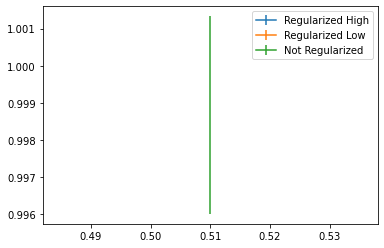

In [9]:
astuteness_mean = total_astuteness.mean(axis=0)
astuteness_std = total_astuteness.std(axis=0)
image_name = 'plots/cxplain_' + datatype + '_astuteness_classifiers.PNG'
fig, ax = plt.subplots()
for i in range(len(lambda_names)):
    ax.errorbar(x=epsilon_range, y=astuteness_mean[i, :], yerr=astuteness_std[i, :],
                label=lambda_names[i])
plt.legend()
plt.savefig(image_name)
plt.show()
plt.close()

In [10]:
x_val.shape

(6000, 100)